<a href="https://colab.research.google.com/github/DiegoOCruz/Artificial-Projeto-de-bloco/blob/main/TP2_PB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(18646, 2)
                                                text  label
0  washington reuters  new jersey governor chris ...      1
1  washington reuters  the leaders of the senate ...      1
2  fairfax va public schools are not unique in th...      0
3  the senate is already rolling back president b...      0
4  washingtonnew york reuters  president barack o...      1
(14916, 5000) (3730, 5000)


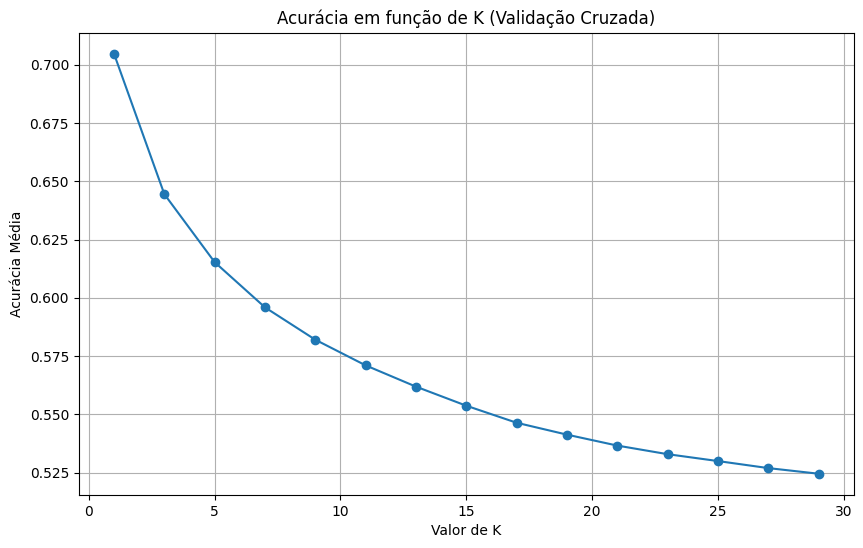

Melhor valor de K: 1
Acurácia: 0.7292225201072386
Precisão: 0.9248046875
Recall: 0.5037234042553191
F1-Score: 0.6522038567493113
Especificidade: 0.9583783783783784

Matriz de Confusão:
[[1773   77]
 [ 933  947]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.66      0.96      0.78      1850
           1       0.92      0.50      0.65      1880

    accuracy                           0.73      3730
   macro avg       0.79      0.73      0.72      3730
weighted avg       0.79      0.73      0.71      3730



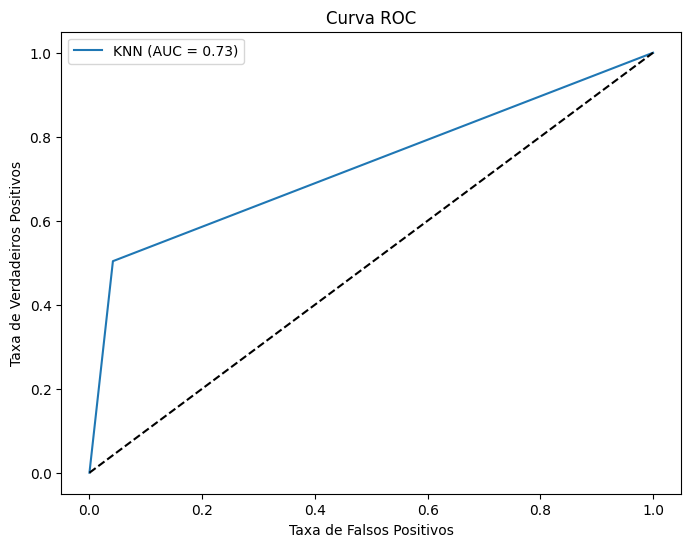

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                            f1_score, confusion_matrix, classification_report,
                            roc_curve, roc_auc_score)

url_fake = "https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/Fake.csv"
url_true = "https://raw.githubusercontent.com/professortiagoinfnet/inteligencia_artificial/refs/heads/main/True.csv"
dados_fake = pd.read_csv(url_fake, header=None)
dados_true = pd.read_csv(url_true, header=None)
dados = pd.concat([dados_fake, dados_true], ignore_index=True)


dados_fake['label'] = 0  #  0  falsa
dados_true['label'] = 1  #  1  verdadeira

dados = pd.concat([dados_fake, dados_true], ignore_index=True)
dados = dados.drop(columns=[0, 2, 3])  # Removendo colunas desnecessárias

dados.columns = ['text', 'label']
dados = dados.sample(frac=1, random_state=42).reset_index(drop=True)  # Embaralhando os dados
# Pré-processamento dos dados
dados['text'] = dados['text'].str.lower()  # Convertendo para minúsculas
dados['text'] = dados['text'].str.replace(r'\d+', '', regex=True)  # Removendo números
dados['text'] = dados['text'].str.replace(r'[^\w\s]', '', regex=True)  # Removendo pontuação
dados['text'] = dados['text'].str.strip()  # Removendo espaços em branco extras
dados = dados.dropna()  # Removendo linhas com valores ausentes
dados = dados[dados['text'].str.len() > 0]  # Removendo linhas com texto vazio

print(dados.shape)

print(dados.head())
#   1. Criação das features: Computar o Term Frequency-Inverse Document Frequency (TF-IDF) para representar a importância das palavras em um conjunto de documentos.
# Vetorização TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_tfidf = vectorizer.fit_transform(dados['text'])

# Divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, dados['label'], test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape)

# 2. Modelagem de K-Nearest Neighbors (KNN): Criar modelos simples de classificação utilizando a base de dados codificada por TF-IDF.
# Testando diferentes valores de K
k_values = range(1, 30, 2)
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plotando os resultados
plt.figure(figsize=(10,6))
plt.plot(k_values, cv_scores, marker='o')
plt.title('Acurácia em função de K (Validação Cruzada)')
plt.xlabel('Valor de K')
plt.ylabel('Acurácia Média')
plt.grid()
plt.show()

# Encontrando o melhor K
best_k = k_values[cv_scores.index(max(cv_scores))]
print(f"Melhor valor de K: {best_k}")

# Treinando o modelo com o melhor K
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)

# Predições
y_pred = best_knn.predict(X_test)

# 4. Avaliação de Classificadores Binários: Utilizar figuras de mérito como Curva ROC, precisão, recall, f1-score, sensibilidade e especificidade para avaliar os modelos.
# Métricas básicas
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precisão:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred))

# ---- CORREÇÃO ----
# Calculando a Especificidade a partir da matriz de confusão
matriz_confusao = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = matriz_confusao.ravel()
especificidade = tn / (tn + fp)
print("Especificidade:", especificidade)
# -----------------------------

# Matriz de confusão
print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, y_pred))

# Relatório completo
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

# Curva ROC
y_prob = best_knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'KNN (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

